# 02: Using logistic regression model for classification on census data 

This project used a binary logistic regression model in BigQuery ML to predict the income range of respondents in the US Census Dataset. The dataset (`census_adult_income`) has about 32561 rows of data. 

## Objective 
1. Create a linear regression model 
1. Evaluate the linear regression model 
1. Make the penguin weight predictions using the linear regression model. 

## Key Concepts
1. Logistic regression 
1. Explainable AI
1. ML.EVALUATE
1. ML PREDICT

## steps
1. Create the dataset 
1. Use the SELECT statement to examine the data 
1. Use the CREATE VIEW statement to compile your training data
1. Use the CREATE MODEL statement to create your logistic regression model. 
1. Use the ML.EVALUATE function to evaluate the model data
1. Use the ML.PREDICT function to predict the income bracket for a given set of census participants.
1. Use the ML.EXPLAIN_PREDICT function to explain prediction results with explainable AI Methods. 
1. Use the ML.GLOBAL_EXPLAIN function to know which features are the most important to determine the income bracket. 

### Dataset

This tutorial uses the [United States Census Income
Dataset](https://archive.ics.uci.edu/ml/datasets/census+income) provided by the
[UC Irvine Machine Learning
Repository](https://archive.ics.uci.edu/ml/index.php). This dataset contains
information about people from a 1994 Census database, including age, education,
marital status, occupation, and whether they make more than $50,000 a year.

Dataset now exists in [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data/):

```
`bigquery-public-data.ml_datasets.census_adult_income`
```




### Goal

The goal is to train a Binary Classification model using  BigQuery ML that predicts
whether a person makes more than $50,000 a year (target label) based on other
Census information about the person (features).

This tutorial focuses more on using this model with  BigQuery ML than on
the design of the model itself. However, it's always important to think about
potential problems and unintended consequences when building machine learning
systems. See the [Machine Learning Crash Course exercise about
fairness](https://developers.google.com/machine-learning/crash-course/fairness/programming-exercise)
to learn about sources of bias in the Census dataset, as well as machine
learning fairness more generally.

## Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. BigQuery is automatically enabled in new projects. [To activate BigQuery in a pre-existing project, go to Enable the BigQuery API.](https://console.cloud.google.com/flows/enableapi?apiid=bigquery)

4. Enter your project ID in the cell below.

In [1]:
PROJECT_ID = "" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the GCP Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. From the **Service account** drop-down list, select **New service account**.

3. In the **Service account name** field, enter a name.

4. From the **Role** drop-down list, select
   **BigQuery > BigQuery Admin** and
   **Storage > Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
computer.

6. Enter the path to your service account key as the `GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below.

In [2]:
import sys

# If you are running this notebook in Colaboratory, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Google Cloud Storage bucket and lets us submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  % env GOOGLE_APPLICATION_CREDENTIALS '/path/to/your/service-account-key.json'


## ML Workflow using a BigQuery model

In this section we will build a Keras model from scratch.
We will perform the following steps:
- Data preparation
- Model creation
- Model training
- Model evaluation
- Model serving

We will create the model and export it to serve requests in BigQuery ML.

### Import libraries
Import supporting modules:

In [3]:
# data processing 
import pandas as pd 

# Visualizations 
import matplotlib.pyplot as plt 
import seaborn as sns 

# BigQuery API 
from google.cloud import bigquery 

# Show software versions 
print(__import__('sys').version)
print(pd.__version__)

3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
1.3.5


### Define Constants

In [4]:
# These are the features in the dataset 
# Dataset information:  https://archive.ics.uci.edu/ml/datasets/census+income
# which exists now in this public dataset:  `bigquery-public-data.ml_datasets.census_adult_income`

_COLUMNS = [
    'age', 'workclass', 'functional_weight', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
    'income_bracket'  
]

# This is the label (target) we want to predict 
_LABEL_COLUMN = 'income_bracket'


#### Unused Features and Features that are Biased

These columns can be skipped when using SQL when creating the training table.

"""
These are columns we will not use as features for training. There are many
reasons not to use certain attributes of data for training. Perhaps their
values are noisy or inconsistent, or perhaps they encode bias that we do not
want our model to learn. For a deep dive into the features of this Census
dataset and the challenges they pose, see the Introduction to ML Fairness
notebook: 
("https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/"
"exercises/intro_to_fairness.ipynb")
"""

UNUSED_COLUMNS = ['functional_weight', 'education', 'sex']

## Data preparation
### Process Numerical and Categorical columns

The Census datasets contains both numbers and strings
we need to convert string data into numbers to be able to train the model. 

**BigQuery ML supports handling categorical data:**

For all non-numeric columns other than TIMESTAMP, BigQuery ML performs a one-hot encoding transformation. This transformation generates a separate feature for each unique value in the column.

Learn more about [feature engineering](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering) and [bias in data](https://developers.google.com/machine-learning/crash-course/fairness/types-of-bias).

### Create BigQuery client

Create a BigQuery client to bundle configuration needed for API requests.

In [6]:
bqml_client = bigquery.Client(location='US', project=PROJECT_ID)

### Create BigQuery dataset

We will create a dataset called `01_bqmlnotebook_census_income_binary_log`, (changed from `census_tutorial` inside this dataset we will create our BQML model.

In [7]:
# Dataset and Table Information 
dataset_name = '01_bqmlnotebook_census_income_binary_log'

dataset = bqml_client.create_dataset(dataset_name)

### Extract Training and Evaluation dataframes:

In this case we will split our data in 80/10/10 for training, validation and testing.

https://www.oreilly.com/learning/repeatable-sampling-of-data-sets-in-bigquery-for-machine-learning

For machine learning, you want repeatable sampling of the data you have in BigQuery. To get the validation data: change the < 8 in the query above to = 8, and for testing data, change it to = 9. This way, you get 10% of samples in validation and 10% in testing.

In [17]:
# This query will process 4.8 MB when run:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
dataset = bqml_client.query(query).to_dataframe()
dataset.head()

,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,34,?,164309,11th,7,Married-civ-spouse,?,Wife,White,Female,0,0,8,United-States,<=50K
1,21,?,212888,11th,7,Married-civ-spouse,?,Wife,White,Female,0,0,56,United-States,<=50K
2,28,?,308493,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,17,Honduras,<=50K
3,47,?,331650,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,8,United-States,>50K
4,22,?,35448,HS-grad,9,Married-civ-spouse,?,Wife,White,Female,0,0,22,United-States,<=50K


### Training dataset

In [9]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
"""
train_dataset = bqml_client.query(query).to_dataframe()

### Evaluation dataset

In [10]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
"""
eval_dataset = bqml_client.query(query).to_dataframe()

### Testing dataset

In [11]:
query = """
SELECT
    age,
    workclass,
    functional_weight,
    education,
    education_num,
    marital_status,
    occupation,
    relationship,
    race,
    sex,
    capital_gain,
    capital_loss,
    hours_per_week,
    native_country,
    income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
WHERE
  MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
"""
test_dataset = bqml_client.query(query).to_dataframe()

#### DataFrame Length

List length of training and testing data. This will validate that dataset contains data before we start processing it.

In [12]:
len(dataset), len(train_dataset), len(eval_dataset), len(test_dataset)

(32561, 26192, 3268, 3101)

### Visualize data

Pandas provides the `.corr` method. Is used to find the pairwise correlation of all columns in the dataframe. Any `na` values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored. 

The term **correlation** refers to a mutual relationship or association between quantities.

The closer ρ is to 1, the more an increase in one variable associates with an increase in the other. On the other hand, the closer ρ is to -1, the increase in one variable would result in a decrease in the other. Note that if X and Y are independent, then ρ is close to 0, but not vice versa! In other words, Pearson correlation can be small even if there is a strong relationship between two variables

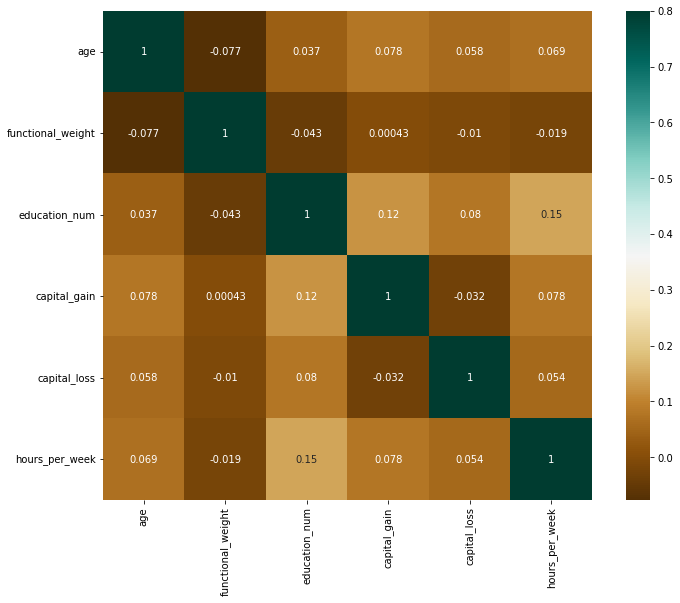

In [14]:
hmap = dataset.corr(method='pearson')
plt.subplots(figsize=(12,9))
sns.heatmap(hmap, vmax=0.8, annot=True, cmap="BrBG", square=True)

When we look at the numerical features they **do not have** a strong correlation. 
The numerical attributes have a significant
number of unique values: 

 - `functional_weight`, has more than 28,000 unique values for a set of ~32000 values. 
 
This may indicate that this feature might not be a significant predictor.

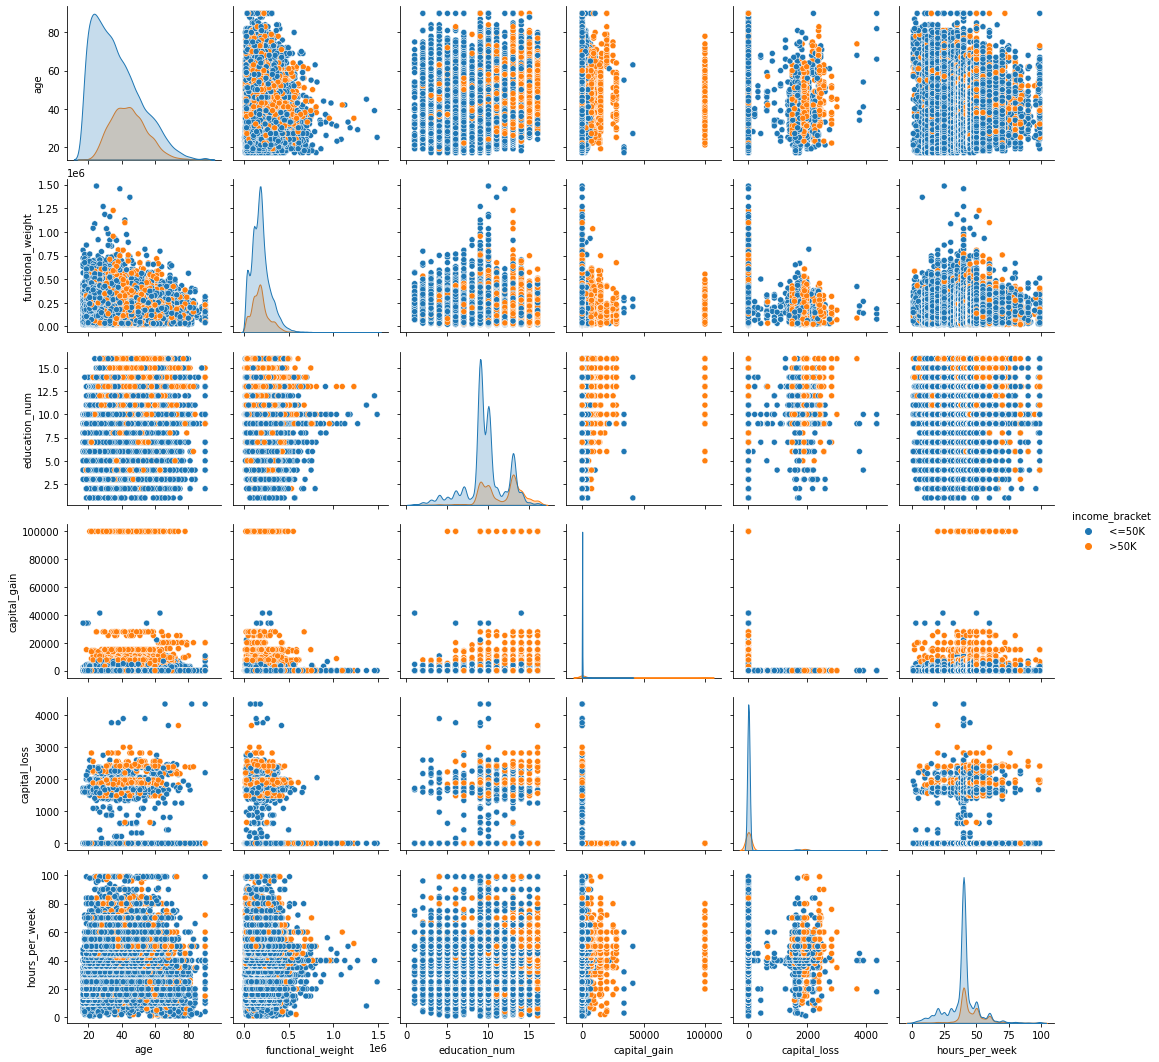

In [15]:
# Visualize interactions 

sns.pairplot (dataset, hue='income_bracket')

In this plot you can see the different samples and their values, this is important when you are doing feature engineering.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


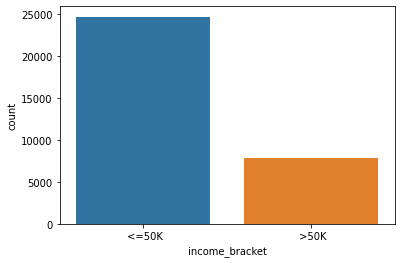

In [16]:
# Count of >50k & <50K 
sns.countplot(dataset['income_bracket'])

There is an imbalance in the proportion of labels, with 24720 values for <=50K, and 7841 for => 50K.
however, 24% of the total should be sufficient to determine class through patterns. In other cases techniques like, [boosting](https://arxiv.org/abs/1706.01531) can be applied.

## Feature Engineering

### Numerical data analysis

We will do a numeric data analysis to check on the different features and the correlation with income bracket.

In the categorical variables, there are three attributes with unknown/missing values:
 - workclass (6%)
 - occupation (6%)
 - native_country (2%) 

In [18]:
# Checking Empty records (NULL) OR (?) and their percentage overall
query = """
SELECT
  COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') AS workclass,
  ROUND(COUNTIF(workclass IS NULL 
    OR LTRIM(workclass) LIKE '?') / COUNT(workclass) * 100) 
    AS workclass_percentage,
  COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') AS occupation,  
  ROUND(COUNTIF(occupation IS NULL 
    OR LTRIM(occupation) LIKE '?') / COUNT(occupation) * 100) 
    AS occupation_percentage,
  COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') AS native_country,
  ROUND(COUNTIF(native_country IS NULL 
    OR LTRIM(native_country) LIKE '?') / COUNT(native_country) * 100) 
    AS native_country_percentage
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
"""
bqml_client.query(query).to_dataframe()

,workclass,workclass_percentage,occupation,occupation_percentage,native_country,native_country_percentage
0,1836,6.0,1843,6.0,583,2.0


In [19]:
# Checking for workclass values.
query = """
SELECT
  workclass,
  COUNT(workclass) AS total_workclass
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY workclass
ORDER BY total_workclass DESC
"""
bqml_client.query(query).to_dataframe()

,workclass,total_workclass
0,Private,22696
1,Self-emp-not-inc,2541
2,Local-gov,2093
3,?,1836
4,State-gov,1298
5,Self-emp-inc,1116
6,Federal-gov,960
7,Without-pay,14
8,Never-worked,7


In [20]:
# Checking for occupation values.
query = """
SELECT
  occupation,
  COUNT(occupation) AS total_occupation
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY occupation
ORDER BY total_occupation DESC
"""
bqml_client.query(query).to_dataframe()

,occupation,total_occupation
0,Prof-specialty,4140
1,Craft-repair,4099
2,Exec-managerial,4066
3,Adm-clerical,3770
4,Sales,3650
5,Other-service,3295
6,Machine-op-inspct,2002
7,?,1843
8,Transport-moving,1597
9,Handlers-cleaners,1370


In [21]:
# Checking for native_country values.
query = """
SELECT
  native_country,
  COUNT(native_country) AS total_native_country
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY native_country
ORDER BY total_native_country DESC
"""
bqml_client.query(query).to_dataframe()

,native_country,total_native_country
0,United-States,29170
1,Mexico,643
2,?,583
3,Philippines,198
4,Germany,137
5,Canada,121
6,Puerto-Rico,114
7,El-Salvador,106
8,India,100
9,Cuba,95


After running the SQL queries above we have found:

 - `workclass` has almost 70% instances of Private, the Unknown (?) can be imputed with this value. 

 - `native_country`, 90% of the instances are `United States` which can be used to impute for the Unknown (?) values. Same cannot be said about `occupation` column as the values are more distributed. 

- `occupation` the missing values account for 6% of the instances, it might be possible to remove these instances without replacement.

Country:
 - Hong: Refers to Hong Kong
 - South: Probably refers to South Korea

In [22]:
# Checking for capital_gain
# Total records: 32561
query = """
SELECT
  capital_gain,
  income_bracket,
  COUNT(capital_gain) AS capital_gain_records
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY capital_gain, income_bracket  
ORDER BY capital_gain_records DESC
"""
bqml_client.query(query).to_dataframe()

,capital_gain,income_bracket,capital_gain_records
0,0,<=50K,23685
1,0,>50K,6164
2,15024,>50K,347
3,7688,>50K,284
4,7298,>50K,246
...,...,...,...
117,7978,<=50K,1
118,6097,>50K,1
119,22040,<=50K,1
120,2387,<=50K,1


In [23]:
# Checking for capital_loss
# Total records: 32561
query = """
SELECT
  capital_loss,
  income_bracket,
  COUNT(capital_loss) AS capital_loss_records
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY capital_loss, income_bracket
ORDER BY capital_loss_records DESC
"""
bqml_client.query(query).to_dataframe()

,capital_loss,income_bracket,capital_loss_records
0,0,<=50K,23974
1,0,>50K,7068
2,1902,>50K,189
3,1977,>50K,168
4,1887,>50K,159
...,...,...,...
94,155,<=50K,1
95,653,<=50K,1
96,2201,>50K,1
97,1844,<=50K,1


Let's take a look at the following numerical attributes:

 - `capital_gain` and `capital_loss` each have close to 100 unique values, although the majority of their instances have zero values. 

 - `capital_gain` has 72% instances with zero values for less than 50K and 19% instances with zero values for >50K. 

 - `capital_loss` has 73% instances with zero values for less than 50K and 21% instances with zero values for >50K. 

This implies that `capital_gain` or `capital_loss` will not make significant predictors either.

In [24]:
# Checking for education
query = """
SELECT
  education,
  education_num      
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY education, education_num
ORDER BY education_num
"""
bqml_client.query(query).to_dataframe()

,education,education_num
0,Preschool,1
1,1st-4th,2
2,5th-6th,3
3,7th-8th,4
4,9th,5
5,10th,6
6,11th,7
7,12th,8
8,HS-grad,9
9,Some-college,10



- `education` and `education_number` are indicators of the same attribute, and are fully correlated with direct mapping, it makes sense to remove one of them during feature selection.

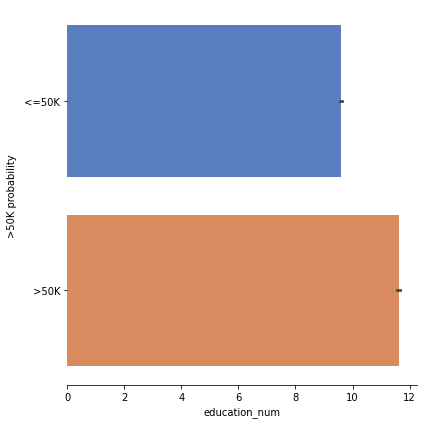

In [25]:
# Explore Education Num vs Income
g = sns.catplot(x="education_num", y="income_bracket", data=dataset,kind="bar", 
                height = 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

In [26]:
# Checking for marital_status
query = """
SELECT
  marital_status            
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY marital_status
"""
bqml_client.query(query).to_dataframe()

,marital_status
0,Married-civ-spouse
1,Married-AF-spouse
2,Never-married
3,Divorced
4,Separated
5,Widowed
6,Married-spouse-absent


In [27]:
# Checking for relationship
query = """
SELECT
  relationship            
FROM 
  `bigquery-public-data.ml_datasets.census_adult_income`
GROUP BY relationship
"""
bqml_client.query(query).to_dataframe()

,relationship
0,Wife
1,Husband
2,Own-child
3,Unmarried
4,Not-in-family
5,Other-relative


As relationship and marital status are features that describe similar status, 
we may be able to drop `relationship` and keep `marital_status`
and create a new feature with new values.

## Model training

We will start Model training using the Public Dataset:

The `CREATE MODEL` clause is used to create and train the model named `census_tutorial.census_model`. 

```
`CREATE OR REPLACE MODEL` 
```

Creates and trains a model and replaces an existing model with the same name in the specified dataset. Documentation [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create)

```
`OPTIONS(model_type='logistic_reg', input_label_cols=['income_bracket'])`
```

Clause indicates that you are creating a logistic regression model. This option creates a logistic regression model or a multiclass logistic regression model. 
For logistic regression models, the label column must contain only two distinct values. When you create a multiclass logistic regression model, specify training data that contains more than two unique labels.

- **model_type:** logistic_reg creates a logistic regression model or a multiclass logistic regression model.

- **auto_class_weights:** By default, the training data used to create a multiclass logistic regression model is unweighted. If the labels in the training data are imbalanced, the model may learn to predict the most popular class of labels more heavily, which may not be desired. Class weights can be used to balance the class labels and can be used for logistic and multiclass logistic regressions. If set to true, the weights for each class are calculated in inverse proportion to the frequency of that class. To balance every class, use the following formula: TOTAL_INPUT_ROWS / (INPUT_ROWS_FOR_CLASS_N * NUMBER_OF_UNIQUE_CLASSES)

- **data_split_method:** The method to split input data into training and evaluation sets. Training data is used to train the model. Evaluation data is used to avoid overfitting via early stopping. The default value is auto_split.

- **input_label_cols:** The label column name(s) in the training data. input_label_cols accepts an array of strings, but only one array element is supported for linear_reg and logistic_reg models. If input_label_cols is unspecified, the column named "label" in the training data is used. If neither exists, the query fails.

- **max_iterations:** The maximum number of training iterations (steps). The default value is 20.


When you use a `CREATE MODEL` statement, the size of the model must be 90 MB or less or the query fails. Generally, if all categorical variables are short strings, a total feature cardinality (model dimension) of 5-10 million is supported. The dimensionality is dependent on the cardinality and length of the string variables.

When you use a `CREATE MODEL` statement, the label column cannot contain NULL values. If the label column contains NULL values, the query fails.

### Standardize data for Model Convergence

1) For all numeric columns, BigQuery ML standardizes and centers the column at zero before passing it into training.

2) In SQL query we skip the following columns for training data:  

`['functional_weight', 'education', 'sex', 'relationship']`

3) Categorical features will be converted to numerical by BQML.

4) The Unknown values in `workclass` and `native_country` are replaced with Private and United States respectively.
The instances with Unknown values for `occupation` are removed.

5) Drop `relationship` and use `marital_status` in a simplified manner. (You can use [Chi Square](https://en.wikipedia.org/wiki/Chi-squared_test) which is commonly used for testing relationships between categorical variables (martial_status vs relationship).

6) Duplicates in the train set are removed.  

Result of the model creation will be an `Empty DataFrame` this is normal.

In [34]:
# Train a BQML model
train_query = """
CREATE OR REPLACE MODEL `01_bqmlnotebook_census_income_binary_log.census_model`
  OPTIONS (
      model_type='logistic_reg',
      auto_class_weights=true,
      data_split_method='no_split',
      input_label_cols=['income_bracket'],
      max_iterations=15) AS
  SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
           'Never-married',
           'Divorced',
           'Separated',
           'Widowed'
          ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
           'Married-civ-spouse',
           'Married-spouse-absent',
           'Married-AF-spouse'
          ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) < 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9
"""
bqml_client.query(train_query)

### Model information

A machine learning algorithm builds a model by examining many examples and attempting to find a model that minimizes loss. This process is called empirical risk minimization.

Loss is the penalty for a bad prediction, a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater. The goal of training a model is to find a set of weights and biases that have low loss, on average, across all examples.

In [35]:
training_info = """
SELECT
  training_run,
  iteration,
  loss,
  eval_loss,
  duration_ms,
  learning_rate
FROM
  ML.TRAINING_INFO(MODEL `01_bqmlnotebook_census_income_binary_log.census_model`)
ORDER BY iteration ASC
"""

bqml_client.query(training_info).to_dataframe()

,training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,0,0,0.668249,None,2277,0.2


## Model evaluation

In [36]:
# Perform model evaluation
query_evaluate = """
SELECT 
  precision,
  recall,
  accuracy,
  f1_score,
  log_loss,
  roc_auc
FROM ML.EVALUATE (MODEL `01_bqmlnotebook_census_income_binary_log.census_model`, 
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
      `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
    ))
"""
evaluation_job = bqml_client.query(query_evaluate).to_dataframe()

### Model results

By examining the ROC accuracy (roc_auc) printed during evaluation, you should see that your model ultimately learned to predict a person's income bracket with around 78% accuracy. Can you improve it?

In [37]:
evaluation_job

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.565176,0.749054,0.78825,0.644252,0.429136,0.867521


### ROC 

The output ML.ROC_CURVE [function](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-roc) includes multiple rows with metrics for different threshold values for the model. The metrics include:

- threshold
- recall
- false_positive_rate
- true_positives
- false_positives
- true_negatives
- false_negatives

More information about these metrics [here](https://en.wikipedia.org/wiki/Precision_and_recall).

In [38]:
# Perform model evaluation
query_roc_curve = """
SELECT
  threshold,
  recall,
  false_positive_rate,
  true_positives,
  false_positives,
  true_negatives,
  false_negatives
FROM
  ML.ROC_CURVE(MODEL `01_bqmlnotebook_census_income_binary_log.census_model`,
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
          (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
       `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 8
      AND (occupation IS NOT NULL OR LTRIM(occupation) NOT LIKE '?%')
    GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9))
"""
roc_curve_job = bqml_client.query(query_roc_curve).to_dataframe()
roc_curve_job

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.423189,0.834805,0.250759,662,578,1727,131
1,0.152425,0.976040,0.537961,774,1240,1065,19
2,0.107254,0.991173,0.640347,786,1476,829,7
3,0.285282,0.918033,0.369631,728,852,1453,65
4,0.488961,0.762926,0.208243,605,480,1825,188
...,...,...,...,...,...,...,...
96,0.764409,0.393443,0.052928,312,122,2183,481
97,0.191676,0.959647,0.476356,761,1098,1207,32
98,0.068360,0.994956,0.746638,789,1721,584,4
99,0.021206,0.998739,0.933623,792,2152,153,1


### Visualize Model history
Model History is everything related to the creation of the model, such as the data used, the parameters, its training, etc. 

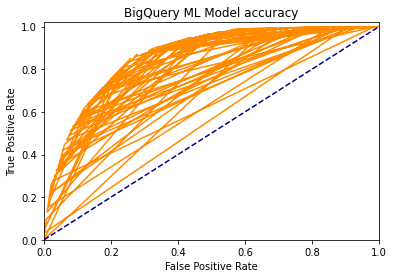

In [39]:
# Visualize History for Accuracy.
plt.title('BigQuery ML Model accuracy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
fpr = roc_curve_job['false_positive_rate']
tpr = roc_curve_job['recall']
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

## Model predictions

#### Generate predictions

Now you will use your model to predict outcomes. The following query uses the ML.PREDICT. The query returns these columns:

 - income_bracket
 - predicted_income_bracket
 - predicted_income_bracket_probs
 - All other columns specified in query.

**Note:** Normally for prediction, your label will be empty, in this example
 we use it to be able to compare the model result vs expected label.

In [45]:
#create variable 

query_prediction = """
SELECT
  income_bracket,
  predicted_income_bracket,
  predicted_income_bracket_probs
FROM
  ML.PREDICT(MODEL `01_bqmlnotebook_census_income_binary_log.census_model`,
  (
    SELECT
      age,
      CASE 
        WHEN workclass IS NULL THEN 'Private' 
        WHEN LTRIM(workclass) LIKE '?' THEN 'Private'
        ELSE workclass
      END AS workclass,
      CASE 
        WHEN native_country IS NULL THEN 'United States' 
        WHEN LTRIM(native_country) LIKE '?' THEN 'United States'
        ELSE native_country
      END AS native_country,        
      CASE 
        WHEN LTRIM(marital_status) IN 
        (
            'Never-married',
            'Divorced',
            'Separated',
            'Widowed'
            ) THEN 'Single' 
        WHEN LTRIM(marital_status) IN 
          (
            'Married-civ-spouse',
            'Married-spouse-absent',
            'Married-AF-spouse'
            ) THEN 'Married' 
        ELSE NULL 
      END AS marital_status,
      education_num,
      occupation,
      race,       
      hours_per_week,        
      income_bracket
    FROM   
       `bigquery-public-data.ml_datasets.census_adult_income`
    WHERE
      MOD(ABS(FARM_FINGERPRINT(CAST(functional_weight AS STRING))), 10) = 9
      AND occupation IS NOT NULL AND LTRIM(occupation) NOT LIKE '?%'
      GROUP BY  1, 2, 3, 4, 5, 6, 7, 8, 9
    ))
"""

#save predictions
predictions = bqml_client.query(query_prediction).to_dataframe()
predictions.head()

,income_bracket,predicted_income_bracket,predicted_income_bracket_probs
0,<=50K,<=50K,"[{'label': ' >50K', 'prob': 0.3889057965303302..."
1,<=50K,<=50K,"[{'label': ' >50K', 'prob': 0.152936845668777}..."
2,>50K,>50K,"[{'label': ' >50K', 'prob': 0.75807008972919},..."
3,<=50K,>50K,"[{'label': ' >50K', 'prob': 0.7950005307989003..."
4,>50K,>50K,"[{'label': ' >50K', 'prob': 0.880886625794794}..."


We will see a few predictions and the expected result:

In [43]:
predictions[['income_bracket', 'predicted_income_bracket']].head()

,income_bracket,predicted_income_bracket
0,<=50K,<=50K
1,<=50K,<=50K
2,>50K,>50K
3,<=50K,>50K
4,>50K,>50K


In [44]:
predictions['predicted_income_bracket_probs'].head()

0    [{'label': ' >50K', 'prob': 0.3889057965303302...
1    [{'label': ' >50K', 'prob': 0.152936845668777}...
2    [{'label': ' >50K', 'prob': 0.75807008972919},...
3    [{'label': ' >50K', 'prob': 0.7950005307989003...
4    [{'label': ' >50K', 'prob': 0.880886625794794}...
Name: predicted_income_bracket_probs, dtype: object

In this case the first prediction probability is ~ 0.53, which corresponds to `>50K`. 
As you can see is very easy to load data into BigQuery and create a model to start training and serving using SQL language only. 

In [46]:
_count = predictions['income_bracket'].str.strip().str.lower() == \
  predictions['predicted_income_bracket'].str.strip().str.lower()
# Group predictions:
_count.value_counts(normalize=True) 
# Note: Set normalize=False to see grouped results.

True     0.791193
False    0.208807
dtype: float64